In [1]:
cd G:\MOPITT\Download

G:\MOPITT\Download


In [2]:

import os
import harp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
from cmcrameri import cm
import requests
import sentinelsat
import shutil
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patheffects as path_effects

In [4]:
filename = "S5P_OFFL_L2__NO2____20221019T233402_20221020T011531_26000_03_020400_20221021T152937.nc"
no2_basic = harp.import_product(filename)

In [5]:
print(no2_basic)

source product = 'S5P_OFFL_L2__NO2____20221019T233402_20221020T011531_26000_03_020400_20221021T152937.nc'

int scan_subindex {time=1877850}
double datetime_start {time=1877850} [seconds since 2010-01-01]
float datetime_length [s]
long orbit_index
long validity {time=1877850}
float latitude {time=1877850} [degree_north]
float longitude {time=1877850} [degree_east]
float latitude_bounds {time=1877850, 4} [degree_north]
float longitude_bounds {time=1877850, 4} [degree_east]
float sensor_latitude {time=1877850} [degree_north]
float sensor_longitude {time=1877850} [degree_east]
float sensor_altitude {time=1877850} [m]
float solar_zenith_angle {time=1877850} [degree]
float solar_azimuth_angle {time=1877850} [degree]
float sensor_zenith_angle {time=1877850} [degree]
float sensor_azimuth_angle {time=1877850} [degree]
double pressure_bounds {time=1877850, vertical=34, 2} [Pa]
float tropospheric_NO2_column_number_density {time=1877850} [mol/m^2]
float tropospheric_NO2_column_number_density_uncer

In [6]:
operations = ";".join([
    "tropospheric_NO2_column_number_density_validity>75",
    "keep(latitude_bounds,longitude_bounds,datetime_start,datetime_length,tropospheric_NO2_column_number_density )",
    "derive(datetime_stop {time} [days since 2000-01-01])",
    "derive(datetime_start [days since 2000-01-01])",
    "exclude(datetime_length)",
    "bin_spatial(721,-90,0.25,1441,-180,0.25)", # lat_cells, corner_lat, lat_resolution, lon_cells, corner_lon, lon_resolution, 
    "derive(tropospheric_NO2_column_number_density [Pmolec/cm2])",
    "derive(latitude {latitude})",
    "derive(longitude {longitude})",
])

In [7]:
reduce_operations = "squash(time, (latitude, longitude, latitude_bounds, longitude_bounds));bin()"

In [8]:
filenames = r"S5P_OFFL_L2__NO2____20221024T*.nc"

In [19]:
merged = harp.import_product(filenames, operations, reduce_operations=reduce_operations)

In [10]:
print(merged)

history = "2023-01-03T13:51:54Z [harp-1.15.1] harp.import_product('S5P_OFFL_L2__NO2____20221024T*.nc',operations='tropospheric_NO2_column_number_density_validity>75;keep(latitude_bounds,longitude_bounds,datetime_start,datetime_length,tropospheric_NO2_column_number_density );derive(datetime_stop {time} [days since 2000-01-01]);derive(datetime_start [days since 2000-01-01]);exclude(datetime_length);bin_spatial(721,-90,0.25,1441,-180,0.25);derive(tropospheric_NO2_column_number_density [Pmolec/cm2]);derive(latitude {latitude});derive(longitude {longitude})',reduce_operations='squash(time, (latitude, longitude, latitude_bounds, longitude_bounds));bin()')"

double datetime_start {time=1} [days since 2000-01-01]
double tropospheric_NO2_column_number_density {time=1, latitude=720, longitude=1440} [Pmolec/cm2]
double datetime_stop {time=1} [days since 2000-01-01]
long count {time=1}
float weight {time=1, latitude=720, longitude=1440}
double latitude_bounds {latitude=720, 2} [degree_north]
doubl

In [12]:
days  = []
np_dates = np.arange('2022-10-20', '2022-10-27', dtype='datetime64[D]')
dates01 = np.datetime_as_string(np_dates, unit='D')
for i in np.arange(0,(len(dates01))):
    dates0 = dates01[i][0:4]+dates01[i][5:7]+dates01[i][8:10]
    days.append(dates0)

In [13]:
data_f = []
for i in days:
    filenames = r"S5P_OFFL_L2__NO2____"+i+"T*.nc"
    merged = harp.import_product(filenames, operations, reduce_operations=reduce_operations)
    data_f.append(merged.tropospheric_NO2_column_number_density.data[0,:,:])
    merged = None

In [14]:
lon = np.arange(-180,180,0.25)
lat = np.arange(-90,90,0.25)

In [18]:
np.array(data_f).shape

(7, 720, 1440)

In [20]:
gridlat = np.append(merged.latitude_bounds.data[:,0], merged.latitude_bounds.data[-1,1])
gridlon = np.append(merged.longitude_bounds.data[:,0], merged.longitude_bounds.data[-1,1])

In [21]:
import xarray as xr

trop_NO2_xarray = xr.Dataset(
    data_vars={"tropospheric_vertical_column_of_NO2": (("days","lat","lon",),np.array(data_f))
              },
    coords = {"lat":(("lat"),lat,),
              "lon":(("lon"),lon),
              "days":(("days"),days),
              "gridlon":(("gridlon"),gridlon),
              "gridlat":(("gridlat"),gridlat)
             },
            
    
    attrs={'Long_name':'Tropospheric Vertical Column of NO2',
           'units':'Pmolec/cm2',
           'title': 'Copernicus Sentinel 5P TROPOMI Tropospheric Vertical Column of NO2',
           'dimensions(sizes)': 'lon(1440), lat(720), time(15))',
           'web-site1':'http://www.tropomi.eu/data-products/level-2-products',
           'web-site2':'https://data-portal.s5p-pal.com/product-docs/no2/PAL_reprocessing_NO2_v02.03.01_20211215.pdf',
           'Instruction':'Kindly use "gridlon" and "gridlat" variable in plotting "pcolormesh"',
           'Author and mail':'K. Madan Mohan Rao and kmmraoiitm@gmail.com'
          })

In [23]:
trop_NO2_xarray.to_netcdf(r'F:\Cyclones\Cyclones\Sitrang\S5P_TROPOMI_tropospheric_vertical_column_of_NO2.nc4')

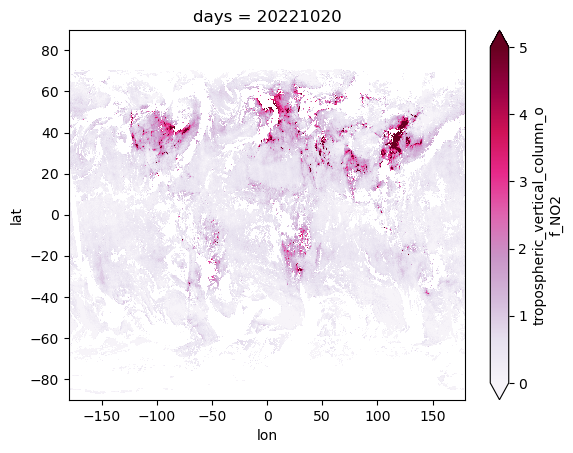

In [26]:
trop_NO2_xarray.tropospheric_vertical_column_of_NO2[0,:,:].plot(cmap='PuRd',vmin=0,vmax=5)

In [27]:
era=xr.load_dataset(r'C:\Users\IITM\INDIA_ERA5_14102022_31102022.nc4')
era_daily = era.resample(time='D').mean()

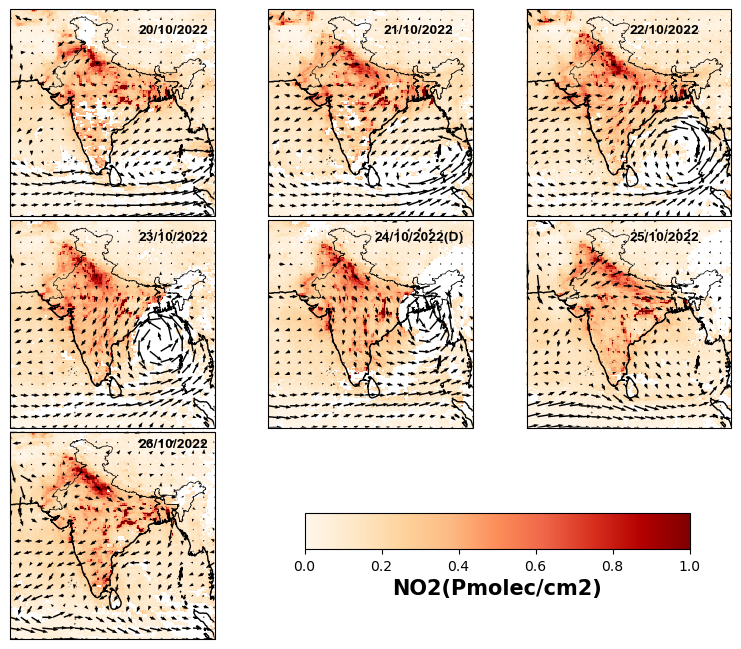

In [30]:
fname= r'F:\Indian Shape Files\Indian Administrative bourders\IND_adm\IND_adm1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())
fname2 = r'F:\Indian Shape Files\Only Indian Boundaries\India_Boundary\India_Boundary.shp'
adm1_shapes2 = list(shpreader.Reader(fname2).geometries())


fig=plt.figure(figsize=(11,9))#,constrained_layout=True)
ax = fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,wspace=0.02, hspace=0.02)


def main():
#***************Total******************************
    ax1 = plt.subplot(3,3, 1, projection=ccrs.PlateCarree())   
    ax1.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
#     ax1.set_title('Total')
    filled_c = ax1.pcolormesh(trop_NO2_xarray.lon, trop_NO2_xarray.lat, trop_NO2_xarray.tropospheric_vertical_column_of_NO2[0,:,:],
                              transform=ccrs.PlateCarree(),vmin=0, vmax=5,cmap='OrRd')
    ax1.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[6,5,:,:]),np.array(era_daily.v[6,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20) 

    ax1.coastlines('50m') 
#     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax1.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax1.text(0.8, 0.9, '20/10/2022', horizontalalignment='center', verticalalignment='center',
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    
    
    ax2 = plt.subplot(3,3, 2, projection=ccrs.PlateCarree())   
    ax2.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
    filled_c = ax2.pcolormesh(trop_NO2_xarray.lon, trop_NO2_xarray.lat, trop_NO2_xarray.tropospheric_vertical_column_of_NO2[1,:,:],
                            transform=ccrs.PlateCarree(),vmin=0, vmax=5,cmap='OrRd')
    ax2.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[7,5,:,:]),np.array(era_daily.v[7,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20)
#                 scale=100,scale_units='xy')
    ax2.coastlines('50m')
    #     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax2.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax2.text(2, 0.9,'21/10/2022', horizontalalignment='center', verticalalignment='center', 
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    
    
    
    ax3 = plt.subplot(3,3, 3, projection=ccrs.PlateCarree())   
    ax3.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
    filled_c = ax3.pcolormesh(trop_NO2_xarray.lon, trop_NO2_xarray.lat, trop_NO2_xarray.tropospheric_vertical_column_of_NO2[2,:,:],
                            transform=ccrs.PlateCarree(),vmin=0, vmax=5,cmap='OrRd')
    ax3.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[8,5,:,:]),np.array(era_daily.v[8,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20)
#                 scale=100,scale_units='xy')
    ax3.coastlines('50m')
#     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax3.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax3.text(3.2,0.9,'22/10/2022', horizontalalignment='center', verticalalignment='center',
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    
    ax4 = plt.subplot(3,3, 4, projection=ccrs.PlateCarree())   
    ax4.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
    filled_c = ax4.pcolormesh(trop_NO2_xarray.lon, trop_NO2_xarray.lat, trop_NO2_xarray.tropospheric_vertical_column_of_NO2[3,:,:],
                            transform=ccrs.PlateCarree(),vmin=0, vmax=5,cmap='OrRd')
    ax4.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[9,5,:,:]),np.array(era_daily.v[9,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20)
#                 scale=100,scale_units='xy')
    ax4.coastlines('50m')
#     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax4.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax4.text(0.8, -0.1, '23/10/2022', horizontalalignment='center', verticalalignment='center', 
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    
    
    ax5 = plt.subplot(3,3,5, projection=ccrs.PlateCarree())   
    ax5.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
    filled_c = ax5.pcolormesh(trop_NO2_xarray.lon, trop_NO2_xarray.lat, trop_NO2_xarray.tropospheric_vertical_column_of_NO2[4,:,:],
                            transform=ccrs.PlateCarree(),vmin=0, vmax=5,cmap='OrRd')
    ax5.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[10,5,:,:]),np.array(era_daily.v[10,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20)

    ax5.coastlines('50m')
#     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax5.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax5.text(2, -0.1, '24/10/2022(D)', horizontalalignment='center', verticalalignment='center',
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    
    
    ax6 = plt.subplot(3,3, 6, projection=ccrs.PlateCarree())   
    ax6.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
    filled_c = ax6.pcolormesh(trop_NO2_xarray.lon, trop_NO2_xarray.lat, trop_NO2_xarray.tropospheric_vertical_column_of_NO2[5,:,:],
                            transform=ccrs.PlateCarree(),vmin=0, vmax=5,cmap='OrRd')
    ax6.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[11,5,:,:]),np.array(era_daily.v[5,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20)
#                 scale=100,scale_units='xy')
    ax6.coastlines('50m')
#     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax6.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax6.text(3.2, -0.1, '25/10/2022', horizontalalignment='center', verticalalignment='center', 
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    
    ax7 = plt.subplot(3,3, 7, projection=ccrs.PlateCarree())   
    ax7.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
    filled_c = ax7.pcolormesh(trop_NO2_xarray.lon, trop_NO2_xarray.lat, trop_NO2_xarray.tropospheric_vertical_column_of_NO2[6,:,:],
                            transform=ccrs.PlateCarree(),vmin=0,vmax=5,cmap='OrRd')
    ax7.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[12,5,:,:]),np.array(era_daily.v[12,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20)
#                 scale=100,scale_units='xy')
    ax7.coastlines('50m')
#     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax7.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax7.text(0.8, -1.1, '26/10/2022', horizontalalignment='center', verticalalignment='center',
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    


#     fig.colorbar(filled_c, ax=ax21, location='bottom')
    
if __name__ == '__main__':
    main()   
    
#ax1 = plt.subplot(3,3, 8, projection=ccrs.PlateCarree())
fig.subplots_adjust(bottom=0.2) 
cbar_ax = fig.add_axes([0.39, 0.3, 0.35, 0.04]) #(w= >away from map, x= position up and down, y= width of cbar, z = height cb)
im =cbar_ax.pcolor(trop_NO2_xarray.lon, trop_NO2_xarray.lat, trop_NO2_xarray.tropospheric_vertical_column_of_NO2[0,:,:],vmin=0,vmax=1,cmap='OrRd')#,60, vmin=0, vmax=1, cmap='jet')
#fig.colorbar(im, cax=cbar_ax)
#im.colorbar()
#plt.show()            0.4, 0.25, 0.4, 0.04

a=fig.colorbar(im, ax = ax, orientation = 'horizontal',cax = cbar_ax)

a.set_label(label='NO2(Pmolec/cm2)',weight='bold', fontsize='15')
plt.savefig(r'F:\Cyclones\Cyclones\Sitrang\plots\TROPMI_tropospheric_vertical_column_of_NO2_SITRANG.jpg',bbox_inches='tight',dpi=720)